In [1]:
import numpy as np
import torch
import cv2
from tqdm import tqdm
import torchvision.models as models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

In [2]:
class Sum_Dataset(Dataset):
    def __init__(self, data_path, lab_path):
        data = np.load(data_path)
        labels = np.load(lab_path)
        self.images = torch.tensor(data, dtype=torch.float32) / 255.0
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [3]:
class ResNet_Model(torch.nn.Module):
    def __init__(self):
        super(ResNet_Model, self).__init__()
        
        # Load the pretrained ResNet50 model
        self.resnet = models.resnet50(weights='IMAGENET1K_V1')
        
        # Change the input layer to accept 1 channel
        self.resnet.conv1 = torch.nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        
        # Change the output layer to output 128 features
        num_features = self.resnet.fc.in_features
        self.resnet.fc = torch.nn.Sequential(
            torch.nn.Linear(num_features, 128),
            torch.nn.ReLU()
        )
        
        # Add a fully connected layer to output the sum
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        return x


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

train_dataset = Sum_Dataset('../DL-Project/data0.npy', '../DL-Project/lab0.npy')
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = Sum_Dataset('../DL-Project/data1.npy', '../DL-Project/lab1.npy')
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Using device: cuda


 10%|█         | 1/10 [00:18<02:44, 18.31s/it]

Epoch [1/10], Train Loss: 4.7598, Val Loss: 5.7067


 20%|██        | 2/10 [00:34<02:15, 16.90s/it]

Epoch [2/10], Train Loss: 4.7703, Val Loss: 4.0071


 30%|███       | 3/10 [00:50<01:55, 16.46s/it]

Epoch [3/10], Train Loss: 1.0300, Val Loss: 3.8886


 40%|████      | 4/10 [01:06<01:37, 16.27s/it]

Epoch [4/10], Train Loss: 3.0187, Val Loss: 3.3466


 50%|█████     | 5/10 [01:21<01:20, 16.08s/it]

Epoch [5/10], Train Loss: 3.8519, Val Loss: 3.3567


 60%|██████    | 6/10 [01:37<01:04, 16.05s/it]

Epoch [6/10], Train Loss: 2.1704, Val Loss: 3.5586


 70%|███████   | 7/10 [01:53<00:47, 15.94s/it]

Epoch [7/10], Train Loss: 1.4724, Val Loss: 2.3760


 80%|████████  | 8/10 [02:09<00:31, 15.83s/it]

Epoch [8/10], Train Loss: 0.9709, Val Loss: 1.9292


 90%|█████████ | 9/10 [02:24<00:15, 15.68s/it]

Epoch [9/10], Train Loss: 2.4975, Val Loss: 5.4599


100%|██████████| 10/10 [02:40<00:00, 16.01s/it]

Epoch [10/10], Train Loss: 0.8201, Val Loss: 1.9018


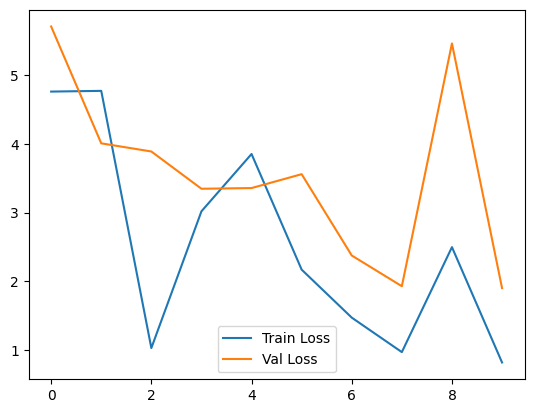

In [5]:
model = ResNet_Model().to(device)
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []

for epoch in tqdm(range(10)):
    model.train()
    for images, labels in train_dataloader:
        images, labels = images.unsqueeze(1).to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.unsqueeze(1).to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs.squeeze(), labels).item()
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/10], Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

In [6]:
torch.save(model.state_dict(), 'digit_sum_model.pth')